klue/roberta-small 모델 사용

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ln -s /content/drive/MyDrive/ /gdrive

In [ ]:
!cp -r /gdrive/aicon/aicon_retrailer data/

In [ ]:
!pip install transformers datasets

     |████████████████████████████████| 2.8 MB 9.4 MB/s 
     |████████████████████████████████| 264 kB 59.3 MB/s 
     |████████████████████████████████| 50 kB 8.9 MB/s 
     |████████████████████████████████| 895 kB 60.0 MB/s 
     |████████████████████████████████| 3.3 MB 54.6 MB/s 
     |████████████████████████████████| 636 kB 74.6 MB/s 
     |████████████████████████████████| 119 kB 88.2 MB/s 
     |████████████████████████████████| 243 kB 74.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
import warnings
import re

import numpy as np
import pandas as pd

import datasets
from datasets import load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import seaborn as sns

#import optuna
#from ray import tune

warnings.filterwarnings(action='ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train = pd.read_csv("./data/train/train.csv")
valid = pd.read_csv("./data/val/val.csv")
test = pd.read_csv("./data/test/test.csv")

In [ ]:
dataset = pd.concat([train, valid], join='inner')

In [ ]:
map_dict = {'AS_날짜_요청': 0,'AS_날짜_질문': 1,'AS_방법_요청': 2,'AS_방법_질문': 3,'AS_비용_요청': 4,'AS_비용_질문': 5,
                        'AS_시간_질문': 6,'AS_일반_질문': 7,'결제_방식_질문': 8,'결제_수단_질문': 9,'결제_시기_질문': 10,'결제_영수증_질문': 11,
                        '결제_오류_질문': 12,'결제_일반_질문': 13,'결제_일반_확인': 14,'결제_재결제_질문': 15,'결제_추가_질문': 16,
                        '결제_취소_질문': 17,'결제_할인_질문': 18,'교환|반품|환불_방법_요청': 19,'교환|반품|환불_방법_질문': 20,
                        '교환|반품|환불_방법_확인': 21,'교환|반품|환불_비용_질문': 22,'교환|반품|환불_시간_요청': 23,
                        '교환|반품|환불_시간_질문': 24,'교환|반품|환불_일반_요청': 25,'교환|반품|환불_일반_질문': 26,
                        '교환|반품|환불_일반_확인': 27,'구매_예약_요청': 28,'구매_예약_질문': 29,'구매_제품_요청': 30,'구매_제품_질문': 31,
                        '매장_이용_요청': 32,'매장_이용_질문': 33,'매장_정보_질문': 34,'멤버십_사용_질문': 35,'멤버십_적립_질문': 36,
                        '배송_날짜_요청': 37,'배송_날짜_질문': 38,'배송_날짜_확인': 39,'배송_방법_요청': 40,'배송_방법_질문': 41,
                        '배송_방법_확인': 42,'배송_비용_질문': 43,'배송_오류_질문': 44,'배송_오류_확인': 45,'배송_일반_요청': 46,
                        '배송_일반_질문': 47,'배송_일반_확인': 48,'배송_지역_요청': 49,'배송_지역_질문': 50,'배송_택배사_질문': 51,
                        '부가서비스_날짜_요청': 52,'부가서비스_날짜_질문': 53,'부가서비스_방법_요청': 54,'부가서비스_방법_질문': 55,
                        '부가서비스_비용_요청': 56,'부가서비스_비용_질문': 57,'웹사이트_사용_질문': 58,'웹사이트_오류_질문': 59,
                        '제품_가격_비교': 60,'제품_가격_요청': 61,'제품_가격_질문': 62,'제품_가격_확인': 63,'제품_구성_요청': 64,
                        '제품_구성_질문': 65,'제품_구성_확인': 66,'제품_날짜_질문': 67,'제품_방법_요청': 68,'제품_방법_질문': 69,
                        '제품_방법_확인': 70,'제품_불량_요청': 71,'제품_불량_질문': 72,'제품_불량_확인': 73,'제품_소재_질문': 74,
                        '제품_시용_요청': 75,'제품_시용_질문': 76,'제품_용도_질문': 77,'제품_용도_확인': 78,'제품_원산지_질문': 79,
                        '제품_일반_비교': 80,'제품_일반_요청': 81,'제품_일반_질문': 82,'제품_일반_확인': 83,'제품_입고_요청': 84,
                        '제품_입고_질문': 85,'제품_재고_요청': 86,'제품_재고_질문': 87,'제품_재고_확인': 88,'제품_정보_비교': 89,
                        '제품_정보_요청': 90,'제품_정보_질문': 91,'제품_정보_확인': 92,'제품_추천_비교': 93,'제품_추천_요청': 94,
                        '제품_추천_질문': 95,'제품_추천_확인': 96,'제품_커스텀_요청': 97,'제품_커스텀_질문': 98,'제품_품질_비교': 99,
                        '제품_품질_요청': 100,'제품_품질_질문': 101,'제품_품질_확인': 102,'제품_호환_질문': 103,'제품_호환_확인': 104,
                        '포장_방식_요청': 105,'포장_방식_질문': 106,'포장_비용_질문': 107,'포장_일반_질문': 108,'행사_기간_질문': 109,
                        '행사_기간_확인': 110,'행사_날짜_질문': 111,'행사_유형_질문': 112,'행사_유형_확인': 113,'행사_일반_질문': 114,
                        '행사_일반_확인': 115,'행사_정보_요청': 116,'행사_정보_질문': 117}

In [ ]:
def set_values(row, value):
    return value[row]

In [ ]:
dataset['label'] = dataset['intent'].apply(set_values, args =(map_dict, ))

In [ ]:
dataset.label.value_counts(sort=False)*100/len(dataset)

0      0.043492
1      0.300441
2      0.183573
3      0.658514
4      0.045360
         ...   
113    0.055232
114    1.678305
115    0.090986
116    0.031752
117    0.771647
Name: label, Length: 118, dtype: float64

In [ ]:
dataset.label.value_counts(sort=False)

0       163
1      1126
2       688
3      2468
4       170
       ... 
113     207
114    6290
115     341
116     119
117    2892
Name: label, Length: 118, dtype: int64

In [ ]:
dataset.label.value_counts(sort = True)

91     72999
38     54908
69     28061
103    24785
65     18246
       ...  
63        71
9         70
78        70
35        66
42        60
Name: label, Length: 118, dtype: int64

In [ ]:
dataset.count()

conv_num    374783
intent      374783
question    374783
answer      374783
label       374783
dtype: int64

In [ ]:
dataset.head()

,conv_num,intent,question,answer,label
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0


In [ ]:
dataset['intent'].fillna('NAN', inplace=True)
dataset['question'].fillna('NAN', inplace=True)
dataset['answer'].fillna('NAN', inplace=True)

In [ ]:
dataset['data'] = dataset['question'] + dataset['answer']
test['data'] = test['question'] + test['answer']

In [ ]:
dataset.head()

,conv_num,intent,question,answer,label,data
0,5087,AS_날짜_요청,제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.,"네, 무상 리퍼 남았는지 확인 도와드리겠습니다.",0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인..."
1,9373,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?,"네, 휴대폰 내일 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다."
2,9374,AS_날짜_요청,오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?,"네, 이번주 안으로 받으실 수 있습니다.",0,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실..."
3,9378,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?,"죄송합니다만, 내일 받아보시는건 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어..."
4,9379,AS_날짜_요청,오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?,"아니요, 내일은 어렵습니다.",0,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다."


In [ ]:
test.head()

,conv_num,question,answer,data
0,9710,노트북 수리 맡기면 바로 받을 수 있나요?,오늘 바로 받으실 수 있어요.,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,9711,노트북 수리 맡기면 오늘 받을 수 있어요?,"네, 오늘 받으실 수 있습니다.","노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,9728,오늘 노트북 수리 들어가면 내일 찾을 수 있죠?,"네, 내일 찾아가세요.","오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,9737,어제 수리맡긴 노트북 내일 찾을 수 있습니까?,"네, 내일 찾으러 오시면 됩니다.","어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,11050,TV AS 이번주 안에 가능한가요?,"네, 이번주까지 해드리겠습니다.","TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


In [ ]:
dataset=dataset[['data','label']]
test=test[['data']]

In [ ]:
dataset.head()

,data,label
0,"제 핸드폰 무상 리퍼 기간 남았는지 확인 좀 해주세요.네, 무상 리퍼 남았는지 확인...",0
1,"오늘 휴대폰 수리 맡기면 내일 받을 수 있나요?네, 휴대폰 내일 받으실 수 있습니다.",0
2,"오늘 휴대폰 수리 맡기면 이번 주 안으로 받을 수 있나요?네, 이번주 안으로 받으실...",0
3,"오늘 휴대폰 수리 맡기면 내일 받을 수 있는거죠?죄송합니다만, 내일 받아보시는건 어...",0
4,"오늘 휴대폰 수리 맡기면 내일까지 받을 수 있을까요?아니요, 내일은 어렵습니다.",0


In [ ]:
test.head()

,data
0,노트북 수리 맡기면 바로 받을 수 있나요?오늘 바로 받으실 수 있어요.
1,"노트북 수리 맡기면 오늘 받을 수 있어요?네, 오늘 받으실 수 있습니다."
2,"오늘 노트북 수리 들어가면 내일 찾을 수 있죠?네, 내일 찾아가세요."
3,"어제 수리맡긴 노트북 내일 찾을 수 있습니까?네, 내일 찾으러 오시면 됩니다."
4,"TV AS 이번주 안에 가능한가요?네, 이번주까지 해드리겠습니다."


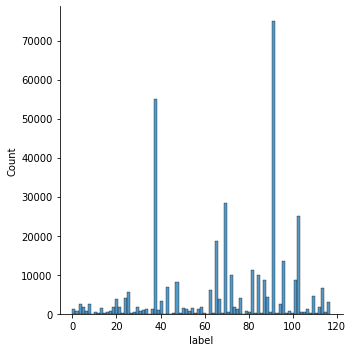

In [ ]:
sns.displot(dataset.label)

In [ ]:
model_checkpoint = "klue/roberta-small"
batch_size = 32
RANDOM_SEED = 42

In [ ]:
target = dataset['label']
dataset_train, dataset_val = train_test_split(dataset,test_size = 0.2, stratify = target, random_state = RANDOM_SEED)

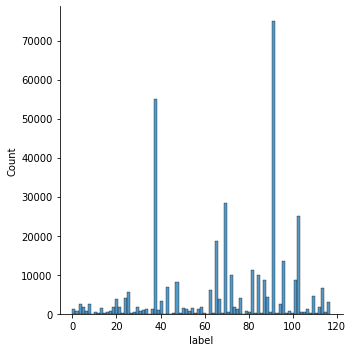

In [ ]:
sns.displot(dataset.label)

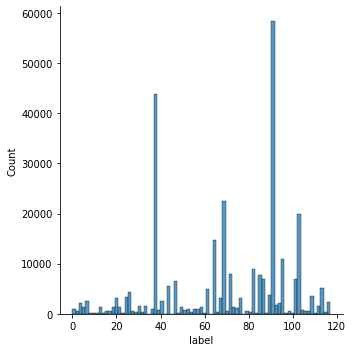

In [ ]:
sns.displot(dataset_train.label)

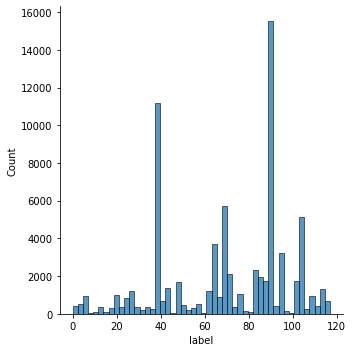

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
def DroppingData(dataset, drop_label, drop_rate):
  counterFunc = dataset.apply(lambda x: True if x['label'] == drop_label else False , axis=1)
  num_rows = len(counterFunc[counterFunc == True].index)
  dropping = int(drop_rate * num_rows)
  dataset = dataset.drop(np.random.choice(dataset.index[dataset['label'].eq(drop_label)], dropping))

  return dataset

In [ ]:
major = [91, 38, 69, 103, 65]

In [ ]:
drop_labels = []
for i in range(118):
  drop_labels.append(i)
for i in major:
  drop_labels.remove(i)
drop_labels

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 66,
 67,
 68,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117]

In [ ]:
len(drop_labels)

113

In [ ]:
for i in major:
   dataset_train = dataset_train[dataset_train['label'] != i]

In [ ]:
for i in major:
   dataset_val = dataset_val[dataset_val['label'] != i]

In [ ]:
dataset_train.label.value_counts(sort = True)

95     10716
82      8986
72      7997
85      7777
101     6918
       ...  
63        57
9         56
78        56
35        53
42        48
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

95     2679
82     2247
72     1999
85     1945
101    1730
       ... 
78       14
45       14
9        14
35       13
42       12
Name: label, Length: 113, dtype: int64

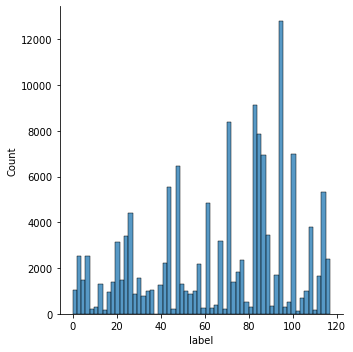

In [ ]:
sns.displot(dataset_train.label)

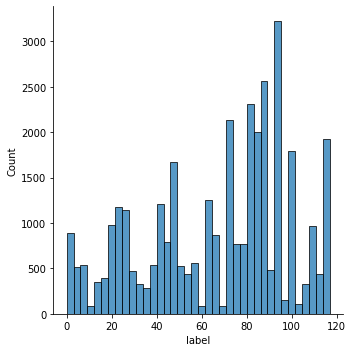

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
for i in drop_labels:
  dataset_train = DroppingData(dataset_train, i, 0.7)

In [ ]:
for i in drop_labels:
  dataset_val = DroppingData(dataset_val, i, 0.7)

In [ ]:
dataset_train.label.value_counts(sort = True)

95    5053
82    4483
72    3764
85    3652
87    3388
      ... 
88      28
78      27
35      27
61      24
42      21
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

95     1296
82     1115
72      987
85      935
101     851
       ... 
45        6
61        6
9         6
63        5
35        4
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_train.count()

data     66005
label    66005
dtype: int64

In [ ]:
dataset_val.count()

data     17104
label    17104
dtype: int64

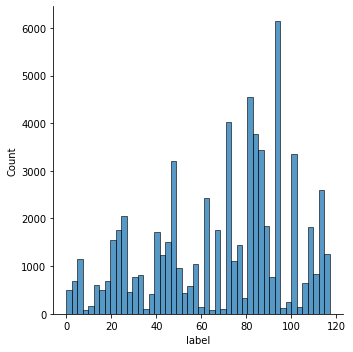

In [ ]:
sns.displot(dataset_train.label)

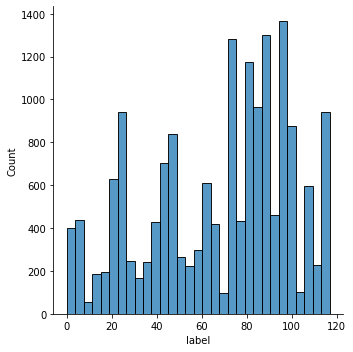

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
changed = []
for i in range(113):
  changed.append(i)

changed

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112]

In [ ]:
mapping = {key:value for key, value in zip(drop_labels, changed) }

mapping

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 66: 64,
 67: 65,
 68: 66,
 70: 67,
 71: 68,
 72: 69,
 73: 70,
 74: 71,
 75: 72,
 76: 73,
 77: 74,
 78: 75,
 79: 76,
 80: 77,
 81: 78,
 82: 79,
 83: 80,
 84: 81,
 85: 82,
 86: 83,
 87: 84,
 88: 85,
 89: 86,
 90: 87,
 92: 88,
 93: 89,
 94: 90,
 95: 91,
 96: 92,
 97: 93,
 98: 94,
 99: 95,
 100: 96,
 101: 97,
 102: 98,
 104: 99,
 105: 100,
 106: 101,
 107: 102,
 108: 103,
 109: 104,
 110: 105,
 111: 106,
 112: 107,
 113: 108,
 114: 109,
 115: 

In [ ]:
for key, value in zip(drop_labels, changed):
  dataset_train['label'] = dataset_train['label'].apply(lambda x: value if x == key else x)

In [ ]:
for key, value in zip(drop_labels, changed):
  dataset_val['label'] = dataset_val['label'].apply(lambda x: value if x == key else x)

In [ ]:
dataset_train.label.value_counts(sort = True)

91    5053
79    4483
69    3764
82    3652
84    3388
      ... 
85      28
35      27
75      27
60      24
41      21
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

91    1296
79    1115
69     987
82     935
97     851
      ... 
44       6
60       6
21       6
62       5
35       4
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_train.count()

data     66005
label    66005
dtype: int64

In [ ]:
dataset_val.count()

data     17104
label    17104
dtype: int64

In [ ]:
for i in range(113):
  counterFunc = dataset_train.apply(lambda x: True if x['label'] == i else False , axis=1)
  numOfRows = len(counterFunc[counterFunc == True].index)
  print(i, end=' ')
  print(numOfRows)

0 39
1 289
2 173
3 640
4 48
5 400
6 168
7 581
8 60
9 29
10 74
11 56
12 41
13 581
14 33
15 49
16 203
17 254
18 293
19 388
20 1526
21 30
22 554
23 43
24 1164
25 80
26 1973
27 44
28 222
29 186
30 509
31 254
32 120
33 253
34 439
35 27
36 65
37 424
38 409
39 220
40 1090
41 21
42 1221
43 1398
44 29
45 71
46 3118
47 91
48 94
49 549
50 323
51 145
52 293
53 129
54 411
55 48
56 481
57 569
58 90
59 43
60 24
61 2368
62 30
63 80
64 196
65 1515
66 57
67 108
68 195
69 3764
70 60
71 598
72 512
73 354
74 1099
75 27
76 223
77 85
78 58
79 4483
80 72
81 45
82 3652
83 57
84 3388
85 28
86 1669
87 153
88 767
89 46
90 1044
91 5053
92 56
93 74
94 161
95 81
96 38
97 3265
98 55
99 153
100 162
101 326
102 156
103 89
104 1734
105 30
106 48
107 753
108 78
109 2518
110 138
111 49
112 1076


In [ ]:
for i in range(113):
  counterFunc = dataset_val.apply(lambda x: True if x['label'] == i else False , axis=1)
  numOfRows = len(counterFunc[counterFunc == True].index)
  print(i, end=' ')
  print(numOfRows)

0 14
1 102
2 65
3 221
4 15
5 152
6 63
7 206
8 16
9 6
10 16
11 15
12 10
13 154
14 10
15 11
16 48
17 67
18 82
19 92
20 381
21 6
22 151
23 21
24 393
25 22
26 506
27 12
28 58
29 49
30 126
31 63
32 34
33 68
34 108
35 4
36 13
37 117
38 100
39 55
40 272
41 7
42 328
43 363
44 6
45 16
46 785
47 15
48 24
49 144
50 86
51 36
52 70
53 36
54 104
55 11
56 126
57 138
58 21
59 11
60 6
61 578
62 5
63 21
64 52
65 368
66 14
67 28
68 57
69 987
70 15
71 155
72 123
73 88
74 284
75 6
76 57
77 23
78 16
79 1115
80 20
81 14
82 935
83 17
84 837
85 7
86 416
87 40
88 192
89 13
90 257
91 1296
92 15
93 17
94 38
95 16
96 10
97 851
98 16
99 42
100 42
101 82
102 40
103 22
104 452
105 8
106 14
107 187
108 19
109 618
110 35
111 11
112 276


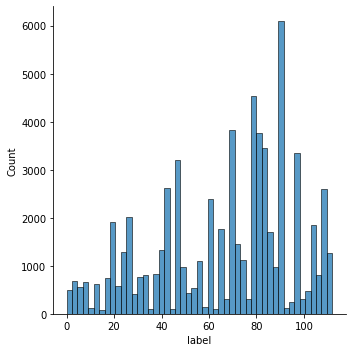

In [ ]:
sns.displot(dataset_train.label)

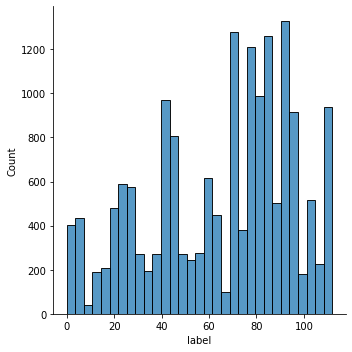

In [ ]:
sns.displot(dataset_val.label)

In [ ]:
ros = RandomOverSampler()
oversampled_data, oversampled_label = ros.fit_resample(dataset_train, dataset_train['label'])
dataset_train = pd.DataFrame(oversampled_data, columns=dataset_train.columns)

In [ ]:
ros = RandomOverSampler()
oversampled_data, oversampled_label = ros.fit_resample(dataset_val, dataset_val['label'])
dataset_val = pd.DataFrame(oversampled_data, columns=dataset_val.columns)

In [ ]:
dataset_train.label.value_counts(sort = True)

112    5053
55     5053
29     5053
30     5053
31     5053
       ... 
78     5053
79     5053
80     5053
81     5053
0      5053
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_val.label.value_counts(sort = True)

112    1296
55     1296
29     1296
30     1296
31     1296
       ... 
78     1296
79     1296
80     1296
81     1296
0      1296
Name: label, Length: 113, dtype: int64

In [ ]:
dataset_train.count()

data     570989
label    570989
dtype: int64

In [ ]:
dataset_val.count()

data     146448
label    146448
dtype: int64

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [ ]:
def tokenized_dataset(dataset, tokenizer):
  tokenized_sentences = tokenizer(
      list(dataset['data']),
      return_tensors="pt",
      padding=True,
      truncation=True
      )
  return tokenized_sentences

In [ ]:
# Dataset 구성.
class ROBERTA_Dataset(Dataset):
    def __init__(self, tokenized_dataset, labels):
        self.tokenized_dataset = tokenized_dataset
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.tokenized_dataset.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)
    
    def get_classes(self):
        return self.labels

In [ ]:
submission = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submission.head()

,conv_num,intent
0,9710,카테고리_채우기
1,9711,카테고리_채우기
2,9728,카테고리_채우기
3,9737,카테고리_채우기
4,11050,카테고리_채우기


In [ ]:
submission['label'] = submission['intent']

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,카테고리_채우기
1,9711,카테고리_채우기,카테고리_채우기
2,9728,카테고리_채우기,카테고리_채우기
3,9737,카테고리_채우기,카테고리_채우기
4,11050,카테고리_채우기,카테고리_채우기


In [ ]:
submission.loc[submission.label == '카테고리_채우기', 'label'] = 0

In [ ]:
submission.head()

,conv_num,intent,label
0,9710,카테고리_채우기,0
1,9711,카테고리_채우기,0
2,9728,카테고리_채우기,0
3,9737,카테고리_채우기,0
4,11050,카테고리_채우기,0


In [ ]:
train_label=dataset_train['label'].values
val_label=dataset_val['label'].values
test_label=submission['label'].values

tokenized_train = tokenized_dataset(dataset_train, tokenizer)
tokenized_val = tokenized_dataset(dataset_val, tokenizer)
tokenized_test = tokenized_dataset(test, tokenizer)

data_train = ROBERTA_Dataset(tokenized_train, train_label)
data_val = ROBERTA_Dataset(tokenized_val, val_label)
data_test = ROBERTA_Dataset(tokenized_test, test_label)

In [ ]:
import gc
gc.collect()

250

In [ ]:
num_labels = 113
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-small and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classif

In [ ]:
metric = load_metric("glue", "mnli")

Downloading:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

In [ ]:
metric_name = "accuracy"

args = TrainingArguments(
    "saved",
    evaluation_strategy="steps",
    save_steps = 28500,
    eval_steps = 28500, 
    logging_steps = 28500, 
    learning_rate=2e-05,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    seed = 42
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_train,
    eval_dataset=data_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19"

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 74957
  Batch size = 8


{'epoch': 1.0,
 'eval_accuracy': 0.701081953653428,
 'eval_loss': 0.9980653524398804,
 'eval_runtime': 332.2098,
 'eval_samples_per_second': 225.631,
 'eval_steps_per_second': 28.205}

In [ ]:
pred = trainer.predict(data_test)
pred = pred[0]
pred

***** Running Prediction *****
  Num examples = 40730
  Batch size = 8


array([[ 6.4870915 ,  8.4103    ,  4.747145  , ...,  0.6087893 ,
         2.420085  ,  1.0981839 ],
       [ 6.8085713 ,  8.017137  ,  4.2598205 , ...,  1.1047946 ,
         2.8239965 ,  1.199438  ],
       [ 6.6804476 ,  7.84601   ,  3.5976577 , ...,  1.0551903 ,
         2.6113577 ,  0.7116377 ],
       ...,
       [ 0.12115587,  0.5435453 , -0.08863654, ...,  1.1791905 ,
         3.883406  ,  9.952028  ],
       [ 0.02692996,  0.49951288, -0.2597607 , ...,  1.0093799 ,
         3.7905507 ,  9.946432  ],
       [ 0.40514532,  1.364173  , -1.0598754 , ...,  1.609789  ,
         2.3209395 ,  7.246991  ]], dtype=float32)

In [ ]:
np.save("/gdrive/aicon/aicon_retrailer/npy/pred_classifier2_0.npy", pred)

In [ ]:
pred = np.argmax(pred,1)
submission['label'] = pred

In [ ]:
#dict_map = {v : k for k, v in map_dict.items()}

#dict_map

{0: 'AS_날짜_요청',
 1: 'AS_날짜_질문',
 2: 'AS_방법_요청',
 3: 'AS_방법_질문',
 4: 'AS_비용_요청',
 5: 'AS_비용_질문',
 6: 'AS_시간_질문',
 7: 'AS_일반_질문',
 8: '결제_방식_질문',
 9: '결제_수단_질문',
 10: '결제_시기_질문',
 11: '결제_영수증_질문',
 12: '결제_오류_질문',
 13: '결제_일반_질문',
 14: '결제_일반_확인',
 15: '결제_재결제_질문',
 16: '결제_추가_질문',
 17: '결제_취소_질문',
 18: '결제_할인_질문',
 19: '교환|반품|환불_방법_요청',
 20: '교환|반품|환불_방법_질문',
 21: '교환|반품|환불_방법_확인',
 22: '교환|반품|환불_비용_질문',
 23: '교환|반품|환불_시간_요청',
 24: '교환|반품|환불_시간_질문',
 25: '교환|반품|환불_일반_요청',
 26: '교환|반품|환불_일반_질문',
 27: '교환|반품|환불_일반_확인',
 28: '구매_예약_요청',
 29: '구매_예약_질문',
 30: '구매_제품_요청',
 31: '구매_제품_질문',
 32: '매장_이용_요청',
 33: '매장_이용_질문',
 34: '매장_정보_질문',
 35: '멤버십_사용_질문',
 36: '멤버십_적립_질문',
 37: '배송_날짜_요청',
 38: '배송_날짜_질문',
 39: '배송_날짜_확인',
 40: '배송_방법_요청',
 41: '배송_방법_질문',
 42: '배송_방법_확인',
 43: '배송_비용_질문',
 44: '배송_오류_질문',
 45: '배송_오류_확인',
 46: '배송_일반_요청',
 47: '배송_일반_질문',
 48: '배송_일반_확인',
 49: '배송_지역_요청',
 50: '배송_지역_질문',
 51: '배송_택배사_질문',
 52: '부가서비스_날짜_요청',
 53: '부가서비스_날짜_질문',
 54: '부가서비스_방법_요청',
 55: '부

In [ ]:
"""
submission['intent'] = submission['label'].apply(set_values, args =(dict_map, ))
submission =submission.drop('label', axis=1)
submission.head()
"""

,conv_num,intent
0,9710,AS_날짜_질문
1,9711,AS_날짜_질문
2,9728,AS_날짜_질문
3,9737,AS_날짜_질문
4,11050,AS_날짜_질문


In [ ]:
submission.to_csv("/gdrive/aicon/aicon_retrailer/result/klue_roberta_small_trainer_classifier2_0.csv",index=False)

In [ ]:
!cp -r ./saved/checkpoint-142500 /gdrive/aicon/aicon_retrailer/backup

참고문헌  
transformers 공식문서 How to fine-tune a model on text classification
https://github.com/huggingface/notebooks/blob/master/examples/text_classification.ipynb  

